In [32]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
df = pd.read_json("usersessions/train.json")
# df_test = pd.read_json("usersessions/test.json")
# df = pd.concat([df_train, df_test])

In [34]:
df.describe()

,user_id
count,60000.000000
mean,99.543133
std,57.762998
min,0.000000
25%,49.000000
50%,100.000000
75%,149.000000
max,199.000000


In [35]:
df['country'] = df.apply(lambda x: x['location'].split('/')[0],axis=1)
df['city'] = df.apply(lambda x: x['location'].split('/')[1],axis=1)


In [36]:
history = df['sites'].apply(pd.Series)
df['number_of_sites'] = df["sites"].apply(len)
df['total_session_time'] = history.apply(lambda x: x.str['length']).sum(axis=1)
df['total_session_site_ratio'] = df['total_session_time'] / df['number_of_sites']

In [37]:
df['is_Joe'] = df.apply(lambda x: 1 if x['user_id'] == 0 else 0, axis=1)

In [38]:
joe = df[df['user_id'] == 0]
joe.head()

,browser,os,locale,user_id,gender,location,sites,time,date,country,city,number_of_sites,total_session_time,total_session_site_ratio,is_Joe
146,Chrome,Windows 10,ru_RU,0,m,USA/Chicago,"[{'site': 'youtube.com', 'length': 71}, {'site...",18:26:00,2016-11-22,USA,Chicago,6,930.0,155.0,1
147,Firefox,Windows 10,ru_RU,0,m,Canada/Toronto,"[{'site': 'mail.google.com', 'length': 140}, {...",16:57:00,2017-08-05,Canada,Toronto,6,648.0,108.0,1
272,Firefox,Windows 10,ru_RU,0,m,USA/Chicago,"[{'site': 'mail.google.com', 'length': 207}, {...",03:42:00,2017-02-19,USA,Chicago,9,1359.0,151.0,1
531,Firefox,Ubuntu,ru_RU,0,m,France/Paris,"[{'site': 'vk.com', 'length': 56}, {'site': 's...",19:15:00,2016-04-08,France,Paris,8,1132.0,141.5,1
605,Firefox,Windows 10,ru_RU,0,m,France/Paris,"[{'site': 'mail.google.com', 'length': 161}, {...",10:04:00,2016-06-19,France,Paris,12,1758.0,146.5,1


In [39]:
def categorial_feature_overview(feature, rotation = 0):
    print(feature, 'has', df[feature].isnull().sum() / len(df) * 100, '% of null values')
    f,ax = plt.subplots(1, 2, figsize=(20, 6))
    ax[0].tick_params(labelrotation = rotation)
    ax[1].tick_params(labelrotation = rotation)
    sns.countplot(data = df, x = feature, ax = ax[0])
    sns.boxplot(data = df, x = feature, y = 'total_session_site_ratio', ax = ax[1])
    plt.show()

browser has 0.0 % of null values


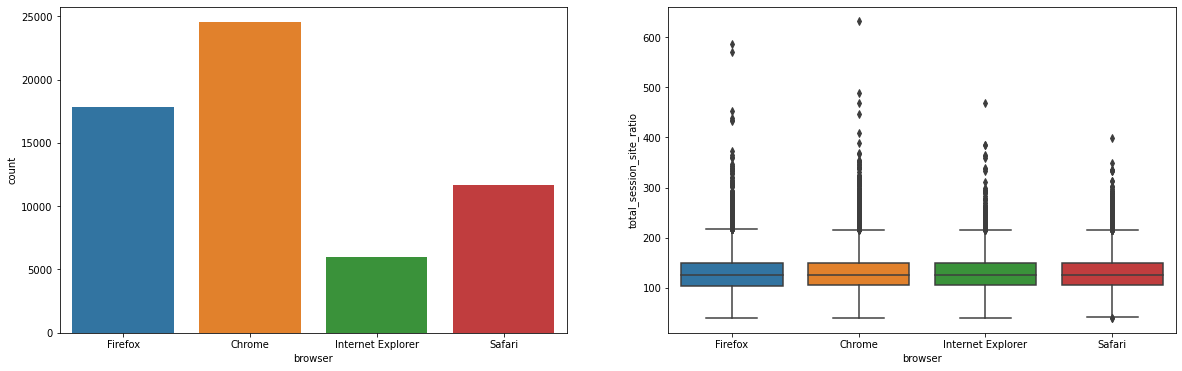

In [40]:
categorial_feature_overview('browser')

os has 0.0 % of null values


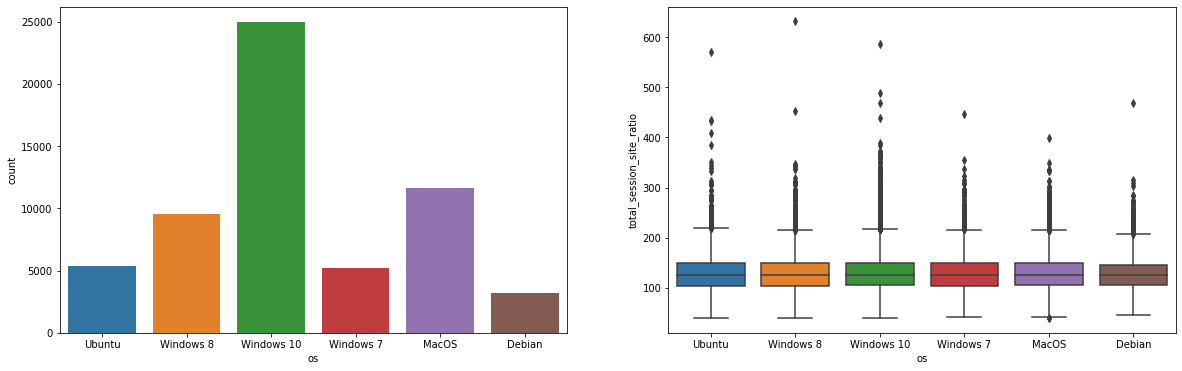

In [41]:
categorial_feature_overview('os')

locale has 0.0 % of null values


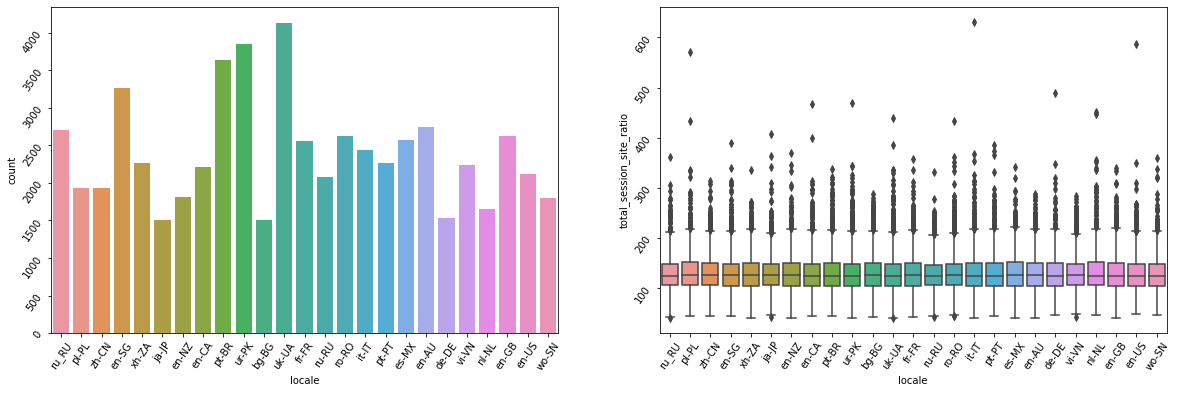

In [42]:
categorial_feature_overview('locale', 55)

gender has 0.0 % of null values


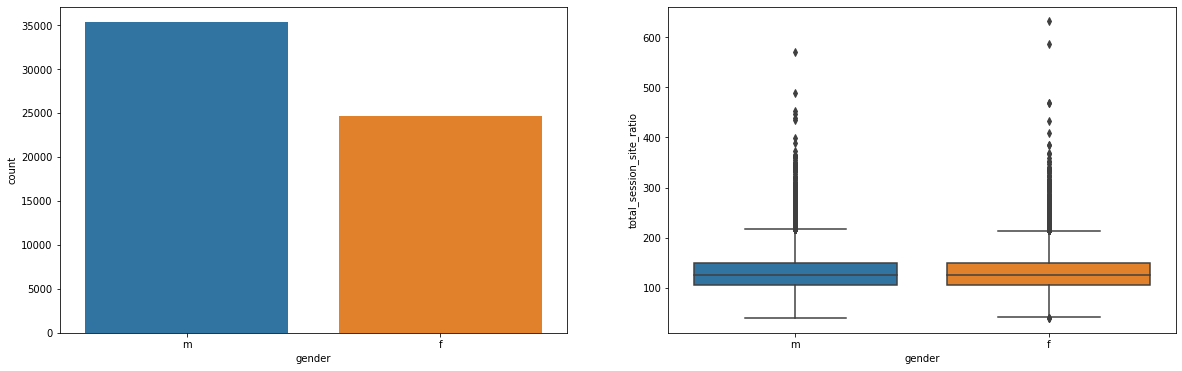

In [43]:
categorial_feature_overview('gender')

country has 0.0 % of null values


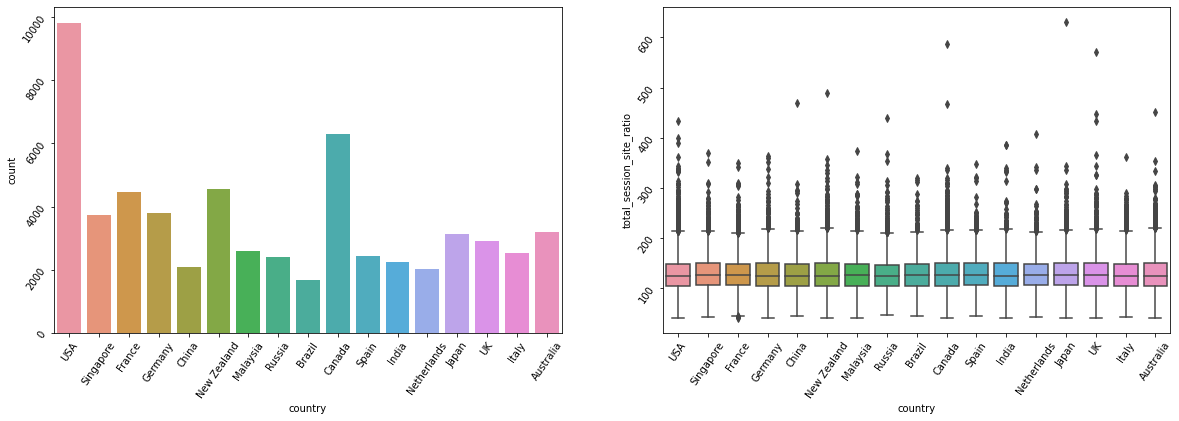

In [44]:
categorial_feature_overview('country', 55)


city has 0.0 % of null values


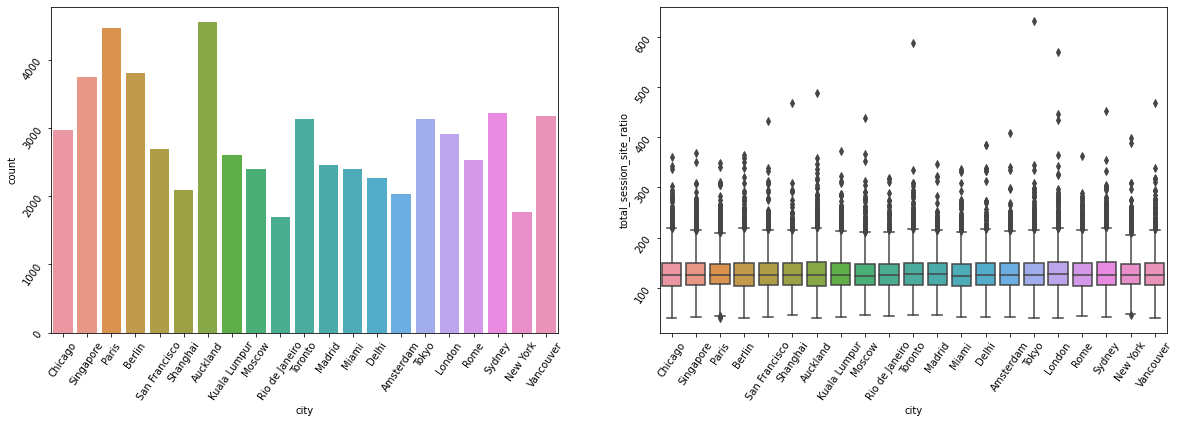

In [45]:
categorial_feature_overview('city', 55)

In [46]:
df['sites'][0][1]

{'site': 'toptal.com', 'length': 132}

In [47]:
history.apply(lambda x: x.str['length']).sum(axis=1)

0         481.0
1        1076.0
2        1280.0
3         224.0
4        1673.0
          ...  
59995     836.0
59996     509.0
59997     267.0
59998     696.0
59999    1597.0
Length: 60000, dtype: float64

In [48]:
df

,browser,os,locale,user_id,gender,location,sites,time,date,country,city,number_of_sites,total_session_time,total_session_site_ratio,is_Joe
0,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,"[{'site': 'mail.google.com', 'length': 50}, {'...",09:03:00,2017-01-08,USA,Chicago,6,481.0,80.166667,0
1,Firefox,Windows 8,pl-PL,11,m,USA/Chicago,"[{'site': 'meduza.org', 'length': 40}, {'site'...",13:57:00,2016-10-05,USA,Chicago,9,1076.0,119.555556,0
2,Chrome,Ubuntu,zh-CN,17,m,Singapore/Singapore,"[{'site': 'facebook.net', 'length': 74}, {'sit...",02:06:00,2017-03-28,Singapore,Singapore,7,1280.0,182.857143,0
3,Firefox,Windows 10,en-SG,92,f,USA/Chicago,"[{'site': 'live.com', 'length': 79}, {'site': ...",00:05:00,2016-02-10,USA,Chicago,2,224.0,112.000000,0
4,Internet Explorer,Windows 8,xh-ZA,120,m,France/Paris,"[{'site': 'cnn.com', 'length': 65}, {'site': '...",14:55:00,2017-03-28,France,Paris,9,1673.0,185.888889,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,Chrome,Windows 8,en-SG,60,f,USA/Chicago,"[{'site': 'toptal.com', 'length': 191}, {'site...",14:59:00,2016-02-01,USA,Chicago,6,836.0,139.333333,0
59996,Chrome,Windows 10,pt-PT,178,m,New Zealand/Auckland,"[{'site': 'vk.com', 'length': 126}, {'site': '...",06:02:00,2016-12-30,New Zealand,Auckland,5,509.0,101.800000,0
59997,Safari,MacOS,it-IT,32,m,Netherlands/Amsterdam,"[{'site': 'slack.com', 'length': 74}, {'site':...",10:27:00,2017-01-27,Netherlands,Amsterdam,4,267.0,66.750000,0
59998,Firefox,Windows 10,ru_RU,56,m,France/Paris,"[{'site': 'lenta.ru', 'length': 82}, {'site': ...",14:17:00,2016-12-06,France,Paris,5,696.0,139.200000,0


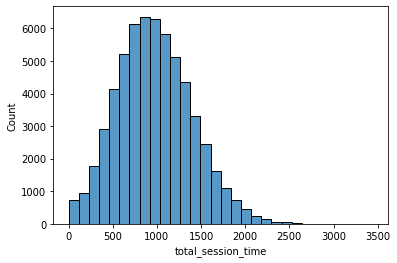

In [49]:
sns.histplot(data = df, x = 'total_session_time', bins=30)
# sns.boxplot(data = df, x = 'total_session_time', y = 'total_session_site_ratio', ax = ax[1], hue = 'is_Joe')
plt.show()

In [50]:
df[["dayofweek", "day", "month"]] = df["date"].apply(lambda x: pd.Series([x.dayofweek, x.day, x.month]))
df["hour"] = df["time"].apply(lambda x: pd.to_datetime(x).hour + pd.to_datetime(x).minute/60)


In [52]:
df.head()

,browser,os,locale,user_id,gender,location,sites,time,date,country,city,number_of_sites,total_session_time,total_session_site_ratio,is_Joe,dayofweek,day,month,hour
0,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,"[{'site': 'mail.google.com', 'length': 50}, {'...",09:03:00,2017-01-08,USA,Chicago,6,481.0,80.166667,0,6,8,1,9.050000
1,Firefox,Windows 8,pl-PL,11,m,USA/Chicago,"[{'site': 'meduza.org', 'length': 40}, {'site'...",13:57:00,2016-10-05,USA,Chicago,9,1076.0,119.555556,0,2,5,10,13.950000
2,Chrome,Ubuntu,zh-CN,17,m,Singapore/Singapore,"[{'site': 'facebook.net', 'length': 74}, {'sit...",02:06:00,2017-03-28,Singapore,Singapore,7,1280.0,182.857143,0,1,28,3,2.100000
3,Firefox,Windows 10,en-SG,92,f,USA/Chicago,"[{'site': 'live.com', 'length': 79}, {'site': ...",00:05:00,2016-02-10,USA,Chicago,2,224.0,112.000000,0,2,10,2,0.083333
4,Internet Explorer,Windows 8,xh-ZA,120,m,France/Paris,"[{'site': 'cnn.com', 'length': 65}, {'site': '...",14:55:00,2017-03-28,France,Paris,9,1673.0,185.888889,0,1,28,3,14.916667


In [86]:
df.fillna(0, inplace=True)

In [87]:
useful_cols = (df.columns).drop(['sites', 'time', 'user_id', 'location','date'])

In [88]:
useful_cols

Index(['browser', 'os', 'locale', 'gender', 'country', 'city',
       'number_of_sites', 'total_session_time', 'total_session_site_ratio',
       'is_Joe', 'dayofweek', 'day', 'month', 'hour'],
      dtype='object')